In [485]:
import numpy as np
import pandas as pa
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
import gensim
import os
from gensim import models,corpora,similarities
from gensim.models import LdaModel
from nltk import FreqDist
from scipy.stats import entropy
from nltk.tokenize import TweetTokenizer,word_tokenize
warnings.filterwarnings('ignore')
sn.set_style("darkgrid")

In [486]:
### Read all the data cleaned
filedir = os.path.abspath(r"C:\Users\BABI\Dynamic Blog Recommendation\Cleaned Data")
medium_filename = "cleaned_medium"
ana_filename = "cleaned_analytics"
toward_filename = "cleaned_towards_data_science"

toward_filepath = os.path.join(filedir,toward_filename)
medium_filepath = os.path.join(filedir,medium_filename)
ana_filepath = os.path.join(filedir,ana_filename)

data_medium = pa.read_csv(medium_filepath)
data_toward = pa.read_csv(toward_filepath)
data_toward = data_toward.rename(columns={'Link':'Links'})
data_ana = pa.read_csv(ana_filepath)
data_ana = data_ana.rename(columns={'Titles':'Title'})
data = pa.concat([data_medium,data_toward])
data = pa.concat([data,data_ana])
data.reset_index(drop=True,inplace=True)

In [487]:
tokenizer = TweetTokenizer()
data_words = data['Description'].apply(lambda x:tokenizer.tokenize(x))
all_words = [word for item in data_words for word in item]
data['tokenized'] = data_words

In [488]:
# Frequency dist of all words
fdist = FreqDist(all_words)

In [489]:
k=13000
top_words = fdist.most_common(k)
print('Last Top Words',top_words[-10:])
print('First Top Words',top_words[0:10])

Last Top Words [('informationfor', 3), ('themlets', 3), ('ly', 3), ('wordclouds', 3), ('personthe', 3), ('learningis', 3), ('train_bow', 3), ('ravinder', 3), ('thi', 3), ('neededi', 3)]
First Top Words [('data', 9381), ('one', 9303), ('use', 8835), ('two', 6639), ('model', 6445), ('learn', 6348), ('hundred', 4550), ('thousand', 4301), ('time', 3628), ('get', 3627)]


In [490]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def store_topwords(words):
    words= [word for word in words if word in top_k_words]
    return words
data['tokenized'] = data['tokenized'].apply(lambda x:store_topwords(x))

In [491]:
data = data[data['tokenized'].map(len) > 30]
data = data[data['tokenized'].map(type)==list]
data.reset_index(drop=True,inplace=True)
data = data.drop(columns=['Unnamed: 0','Unnamed: 0.1'],axis=1)
print('Data Shape',data.shape)

Data Shape (730, 4)


In [492]:
## Training the lda model
#mask = np.random.rand(len(data)) < 0.999
#train_data  = data[mask]
train_data = data
test_data = train_data.iloc[230]#give a blog to predict
train_data = train_data.drop(index=230,axis=0)
#train_data.reset_index(drop=True,inplace=True)
#test_data = data[~mask]
#test_data.reset_index(drop=True,inplace=True)

In [493]:
train_data.reset_index(drop=True,inplace=True)

### Latent Direchlet Allocation

In [494]:
def lda_model(train_data):
    num_topics = 8
    chunksize = 250
    dictionary = corpora.Dictionary(train_data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in train_data['tokenized']]
    
    #Define the lda model
    lda = LdaModel(corpus=corpus,num_topics=num_topics,id2word=dictionary,alpha=0.8e-1,eta=0.02e-3,chunksize=chunksize,
                  minimum_probability=0.0,passes=2)
    return dictionary,corpus,lda

In [495]:
dictionary,corpus,lda = lda_model(data)

In [496]:
### Topic Visulalization
lda.show_topics(num_topics=20,num_words=20)

[(0,
  '0.027*"one" + 0.018*"series" + 0.018*"time" + 0.016*"two" + 0.011*"use" + 0.010*"hundred" + 0.010*"value" + 0.010*"model" + 0.009*"thousand" + 0.008*"three" + 0.008*"x" + 0.007*"function" + 0.007*"data" + 0.007*"five" + 0.006*"plot" + 0.006*"find" + 0.006*"would" + 0.005*"get" + 0.005*"make" + 0.005*"follow"'),
 (1,
  '0.012*"—" + 0.010*"one" + 0.006*"thousand" + 0.006*"two" + 0.005*"is" + 0.005*"use" + 0.005*"time" + 0.005*"not" + 0.005*"like" + 0.004*"hundred" + 0.004*"make" + 0.004*"work" + 0.004*"say" + 0.004*"may" + 0.004*"us" + 0.004*"also" + 0.004*"it" + 0.004*"people" + 0.004*"new" + 0.004*"take"'),
 (2,
  '0.016*"use" + 0.014*"learn" + 0.014*"one" + 0.011*"data" + 0.010*"network" + 0.008*"cluster" + 0.008*"word" + 0.008*"neural" + 0.008*"two" + 0.008*"deep" + 0.007*"train" + 0.007*"image" + 0.007*"article" + 0.007*"model" + 0.006*"layer" + 0.006*"thousand" + 0.005*"text" + 0.005*"output" + 0.005*"hundred" + 0.005*"let"'),
 (3,
  '0.024*"data" + 0.020*"use" + 0.017*"mod

In [497]:
train_rand = np.random.randint(len(train_data))
bow = dictionary.doc2bow(train_data['tokenized'].iloc[train_rand])

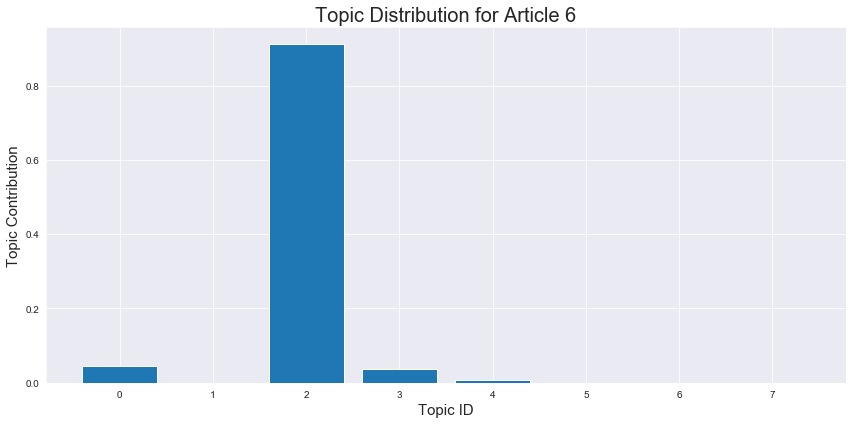

In [498]:
## Topic distribution of that particular document 
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(train_rand), fontsize=20)
fig.tight_layout()
plt.show()

##Visualize the cluster of this particular document

In [499]:
for i in doc_distribution.argsort()[::-1][:7]:
    print(i,lda.show_topic(topicid=i,topn=10),"\n")

2 [('use', 0.016039697), ('learn', 0.014074793), ('one', 0.013535415), ('data', 0.011082179), ('network', 0.009537665), ('cluster', 0.008422134), ('word', 0.008366629), ('neural', 0.0077540823), ('two', 0.0076604635), ('deep', 0.0075320187)] 

0 [('one', 0.027118627), ('series', 0.018332705), ('time', 0.01832275), ('two', 0.016110359), ('use', 0.011036449), ('hundred', 0.010486483), ('value', 0.010483826), ('model', 0.009701766), ('thousand', 0.008774083), ('three', 0.008240397)] 

3 [('data', 0.023608064), ('use', 0.020003052), ('model', 0.016998077), ('learn', 0.013921551), ('one', 0.012501142), ('two', 0.0103333965), ('article', 0.007515708), ('machine', 0.007217017), ('value', 0.006270634), ('feature', 0.0057294173)] 

4 [('hundred', 0.03919832), ('one', 0.03522993), ('two', 0.021772947), ('thousand', 0.019743728), ('three', 0.016368851), ('five', 0.015292486), ('model', 0.013443089), ('value', 0.012733011), ('four', 0.012468256), ('seven', 0.01108261)] 

5 [('air', 0.016617993), (

In [500]:
### Simlilarity for unseen data

In [501]:
### Select random from test data
#test_data_index = np.random.randint(len(test_data))
test_bow = dictionary.doc2bow(test_data['tokenized'])

In [502]:
test_data['Links']

'https://arcdigital.media/the-pantry-police-a236e9b148b4?source=extreme_main_feed---------242-74--------------------ae741f88_52e6_4632_b2d4_d4446ba00442--4'

In [503]:
### Check the topic distribution
test_topic_dist = np.array([tup[1]  for tup in lda.get_document_topics(bow=test_bow)]) 

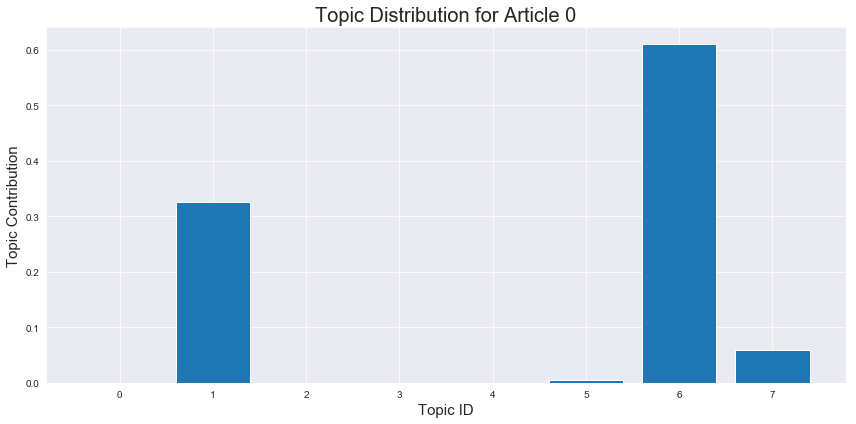

In [504]:
## Topic distribution of that particular document 
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(test_topic_dist)), test_topic_dist)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(test_data_index), fontsize=20)
fig.tight_layout()
plt.show()
##Visualize the cluster of this particular document

In [505]:
##### Find similer topics usning JSD

In [506]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(730, 8)

In [507]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [508]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [509]:
most_sim_ids = get_most_similar_documents(test_topic_dist,doc_topic_dist)

In [510]:
most_sim_documents = train_data[train_data.index.isin(most_sim_ids)]

In [528]:
#most_sim_documents['Title']

In [527]:
#most_sim_documents['Links']

In [526]:
for i in range(0,10):
    print('Title {}"\n"Link--{}'.format(most_sim_documents['Title'].iloc[i],
                                      most_sim_documents['Links'].iloc[i]))
    print('******************************')

Title Data Science, Disney & Tindering"
"Link--https://towardsdatascience.com/developing-successful-data-science-career-30b20a8892f6?source=extreme_main_feed---------35-58--------------------ae741f88_52e6_4632_b2d4_d4446ba00442--7
******************************
Title I’m a Nurse at the Epicenter of this Pandemic"
"Link--https://medium.com/@adara.abrahamsen/im-a-nurse-at-the-epicenter-of-this-pandemic-3fe3820d6e66?source=extreme_main_feed---------78-73--------------------ae741f88_52e6_4632_b2d4_d4446ba00442--
******************************
Title How Will We Prepare for the Future?"
"Link--https://medium.com/the-ascent/how-will-we-prepare-for-the-future-7470ff14951e?source=extreme_main_feed---------97-49----------bd856b86de98----------ae741f88_52e6_4632_b2d4_d4446ba00442--9
******************************
Title No One Should Want a Return to Normalcy"
"Link--https://gen.medium.com/no-one-should-want-a-return-to-normalcy-a1091120d7d8?source=extreme_main_feed---------124-73-----------------

In [1]:
#most_sim_documents